In [1]:
import numpy as np
import scipy.linalg
from scipy.linalg import eig
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.optimize import curve_fit

import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

from general_graph_utils import *

In [2]:
def compute_entropy_production(n_ATP, n_ADP):
    if n_ATP > 0 and n_ADP > 0:
        return np.log(n_ATP / n_ADP) # the affinity of the system is given by this
    return -np.inf

def construct_transition_matrix(N, n_ATP, n_ADP):
    Q = np.zeros((N, N))
    for i in range(N):
        next_i = (i + 1) % N # define the next index mod N
        prev_i = (i - 1) % N # define the prev index mod N
        
        delta_s = compute_entropy_production(n_ATP, n_ADP) # compute entropy
        k_minus = 1.0 # define the reverse rate
        k_plus = k_minus * np.exp(delta_s) # define the forward rate

        Q[i, next_i] = k_plus if n_ATP > 0 else 0 # enter the off diagonal entry for k+
        Q[i, prev_i] = k_minus if n_ADP > 0 else 0 # enter the off diagonal entry for k-
        Q[i, i] = -(Q[i, next_i] + Q[i, prev_i]) # enter the diagonal entry
    return Q

def compute_oscillation_coherence(Q):
    eigenvalues = eig(Q, right=False) # extract the eigenvalues only
    eigenvalues = sorted(eigenvalues, key=lambda x: np.real(x)) # sort the eigenvalues by their real part
    lambda_1 = eigenvalues[-2]  # extract the first nontrivial eigenvalue
    X_R, X_I = np.real(lambda_1), np.imag(lambda_1) # define its real and imaginary part
    return abs(X_I / X_R) if X_R != 0 else np.inf # take the ratio, which is the coherence R

In [3]:
# 3D trajectories
def gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init):
    state = 0 # initial state
    time = 0.0 # initial time
    n_ATP, n_ADP = n_ATP_init, n_ADP_init # initialize ATP, ADP concentrations
    
    # create data structures to track information we want
    
    trajectory = [(time, state, n_ATP, n_ADP)] 
    states_visited = [state]
    coherence_record = []
    atp_record = []
    transition_matrices = []
   
    # Gillespie algorithm
    while time < T_max:
        
        # define new transition rates given current ATP, ADP levels
        delta_s = compute_entropy_production(n_ATP, n_ADP)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        forward_rate = k_plus if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0
        
        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break
        
        # add time delay to current time
        tau = -np.log(np.random.rand()) / total_rate
        time += tau

        if time > T_max:
            break
            
        # forward transition depletes ATP
        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N
            n_ATP = max(n_ATP - 1, 0)
            n_ADP += 1
        
        # reverse transition 
        else:
            state = (state - 1) % N
            n_ATP += 1
            n_ADP = max(n_ADP - 1, 0)
            
        # update data structures and store ATP concentration
        trajectory.append((time, state, n_ATP, n_ADP))
        states_visited.append(state)
        atp_record.append((time,n_ATP))

        # compute the coherence
        Q = construct_transition_matrix(N, n_ATP, n_ADP)
        coherence = compute_oscillation_coherence(Q)
        coherence_record.append((time, coherence))
        transition_matrices.append((time, Q.copy()))
    
    return trajectory, coherence_record, atp_record, transition_matrices, states_visited

In [12]:
# Plotting functions

def plot_trajectory_3d(trajectory, atp_threshold=10):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    times, states, atp_levels, adp_levels = zip(*trajectory)
    
    points = np.array([times, atp_levels, states]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    norm = plt.Normalize(times[0], times[-1])
    lc = Line3DCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.array(times))
    lc.set_linewidth(2)
    
    ax.add_collection3d(lc)
    
    depleted_indices = [i for i, atp in enumerate(atp_levels) if atp < atp_threshold]
    if depleted_indices:
        ax.scatter(
            [times[i] for i in depleted_indices],
            [atp_levels[i] for i in depleted_indices],
            [states[i] for i in depleted_indices],
            color='red', marker='*', s=100, label='ATP depleted'
        )
    
    ax.set_xlabel("Time")
    ax.set_ylabel("ATP Levels")
    ax.set_zlabel("State i")
    ax.set_title("3D Trajectory with Time Color and ATP Depletion Markers")
    
    ax.set_xlim(min(times), max(times))
    ax.set_ylim(min(atp_levels), max(atp_levels))
    ax.set_zlim(min(states), max(states))
    
    plt.colorbar(lc, ax=ax, label='Time progression')
    if depleted_indices:
        ax.legend()
    plt.savefig('trajectory.png')
    plt.show()

def plot_states(states_visited):
    times, coherences = zip(*coherence_record)
    plt.figure()
    plt.plot(times, states_visited[:-1], '-o', color = 'green')
    plt.xlabel('Time')
    plt.ylabel('States visited')
    plt.title('States visited over Time')
    plt.grid(True)
    plt.savefig('states.png')
    plt.show()
    
def plot_coherence(coherence_record):
    times, coherences = zip(*coherence_record)
    plt.figure()
    plt.plot(times, coherences, '-o', color = 'blue')
    plt.xlabel('Time')
    plt.ylabel('Oscillation Coherence (X_I / X_R)')
    plt.title('Oscillation Coherence over Time')
    plt.grid(True)
    plt.savefig('coherence.png')
    plt.show()
    
def plot_atp(atp_record):
    times, atp = zip(*atp_record)
    plt.figure()
    plt.plot(times, atp, '-o', color = 'red')
    plt.xlabel('Time t')
    plt.ylabel('ATP levels [ATP](t)')
    plt.title('ATP levels over Time')
    plt.grid(True)
    plt.savefig('atp.png')
    plt.show()
    
def plot_both_aligned(coherence_record, atp_record, method='normalize'):
    times_coh, coherences = zip(*coherence_record)
    times_atp, atp = zip(*atp_record)

    if method == 'normalize':
        # Normalize both to [0, 1]
        coh_min, coh_max = min(coherences), max(coherences)
        atp_min, atp_max = min(atp), max(atp)

        norm_coh = [(c - coh_min) / (coh_max - coh_min) for c in coherences]
        norm_atp = [(a - atp_min) / (atp_max - atp_min) for a in atp]

        label_coh = 'Coherence (normalized)'
        label_atp = 'ATP (normalized)'

    elif method == 'rescale_atp':
        # Rescale ATP to match coherence range directly
        coh_min, coh_max = min(coherences), max(coherences)
        atp_min, atp_max = min(atp), max(atp)

        scale = (coh_max - coh_min) / (atp_max - atp_min)
        shift = coh_min - scale * atp_min
        norm_coh = coherences
        norm_atp = [scale * a + shift for a in atp]

        label_coh = 'Coherence'
        label_atp = 'ATP (rescaled)'

    else:
        raise ValueError("Method must be 'normalize' or 'rescale_atp'.")

    plt.figure(figsize=(8, 5))
    plt.plot(times_coh, norm_coh, '-o', color='red', label=label_coh)
    plt.plot(times_atp, norm_atp, '-o', color='blue', label=label_atp)
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title('Coherence and ATP Curves (Shape Comparison)')
    plt.legend()
    plt.grid(True)
    plt.savefig('atp_coherence.png')
    plt.show()

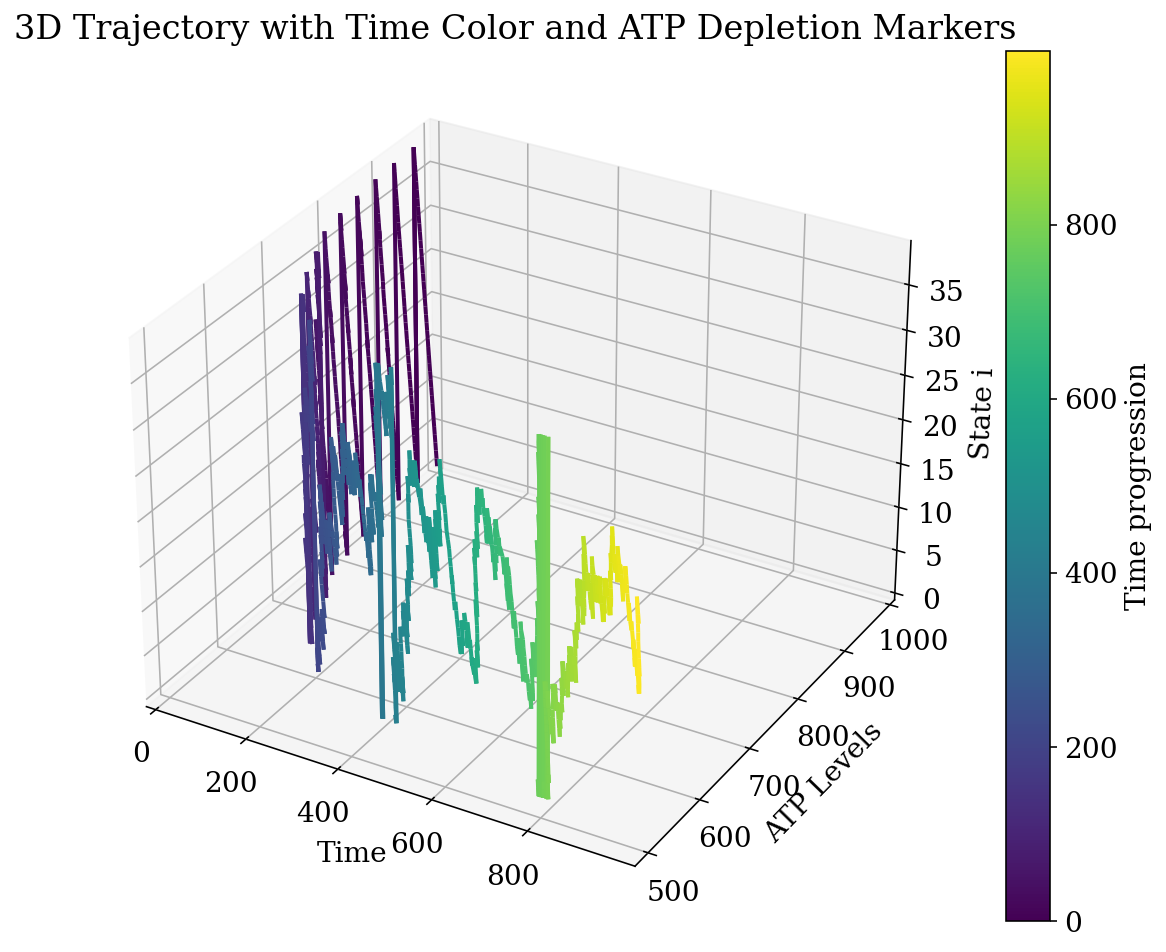

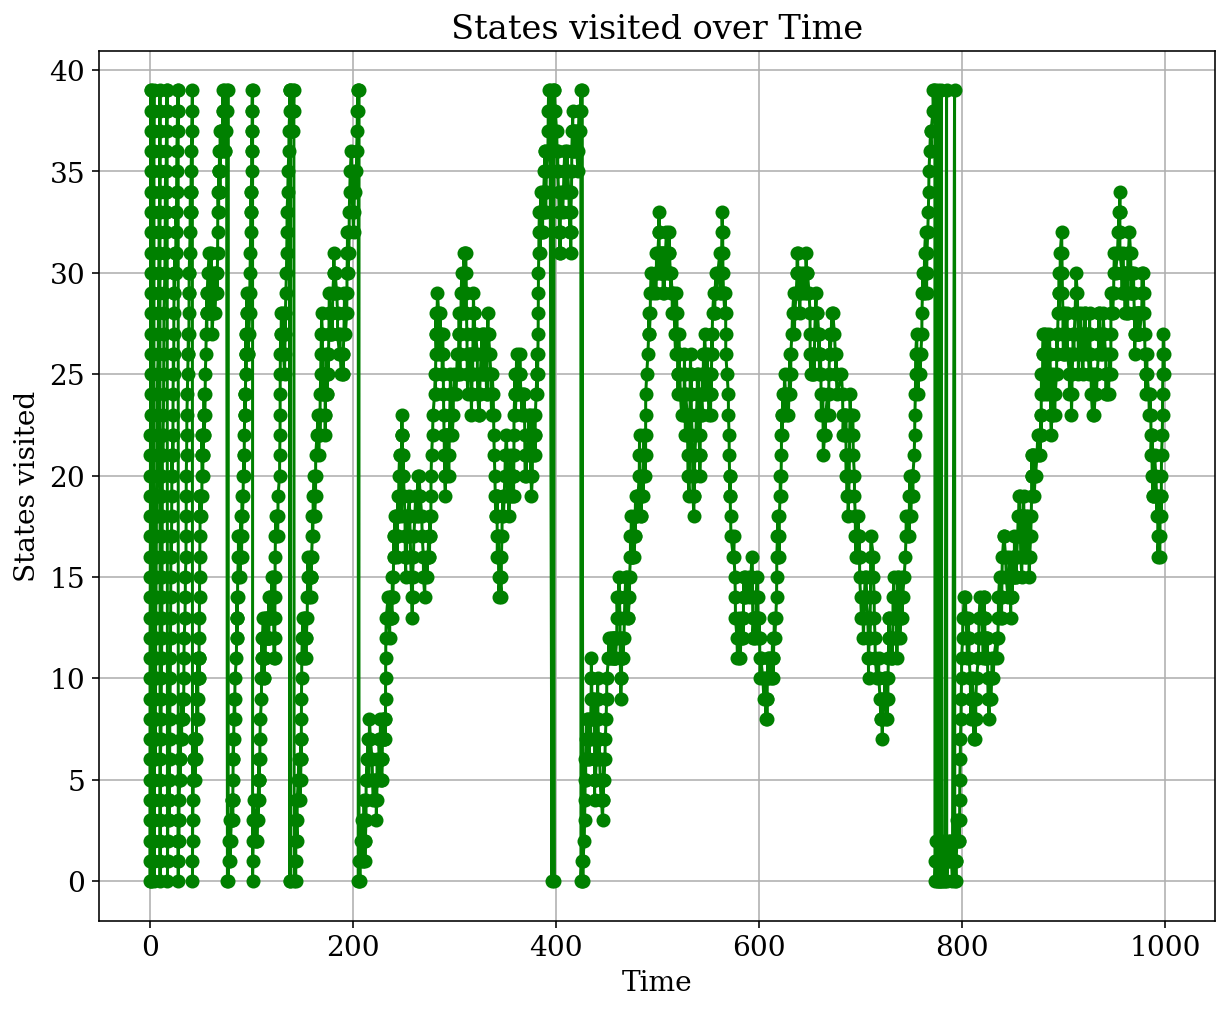

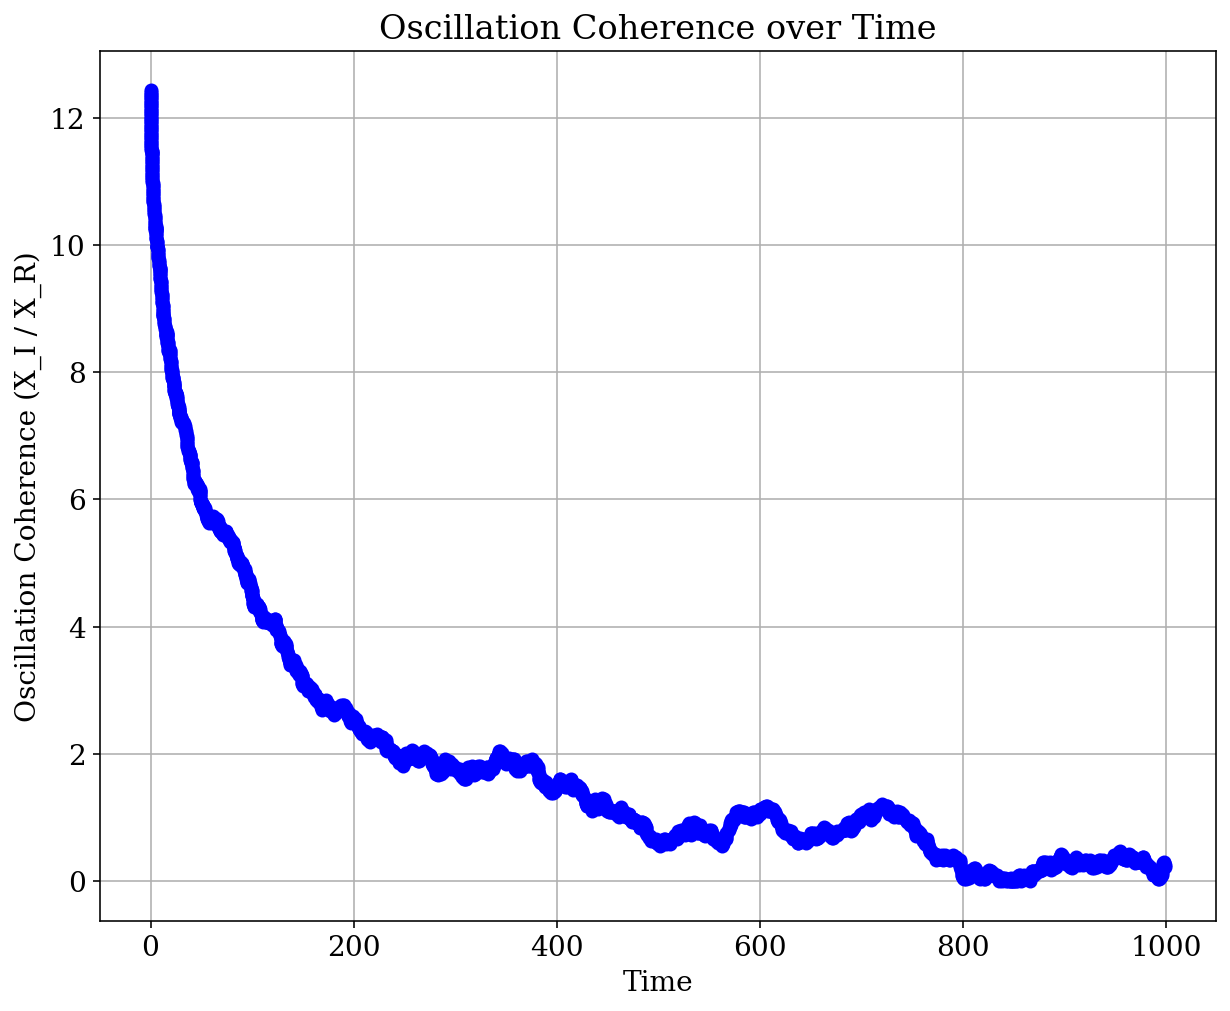

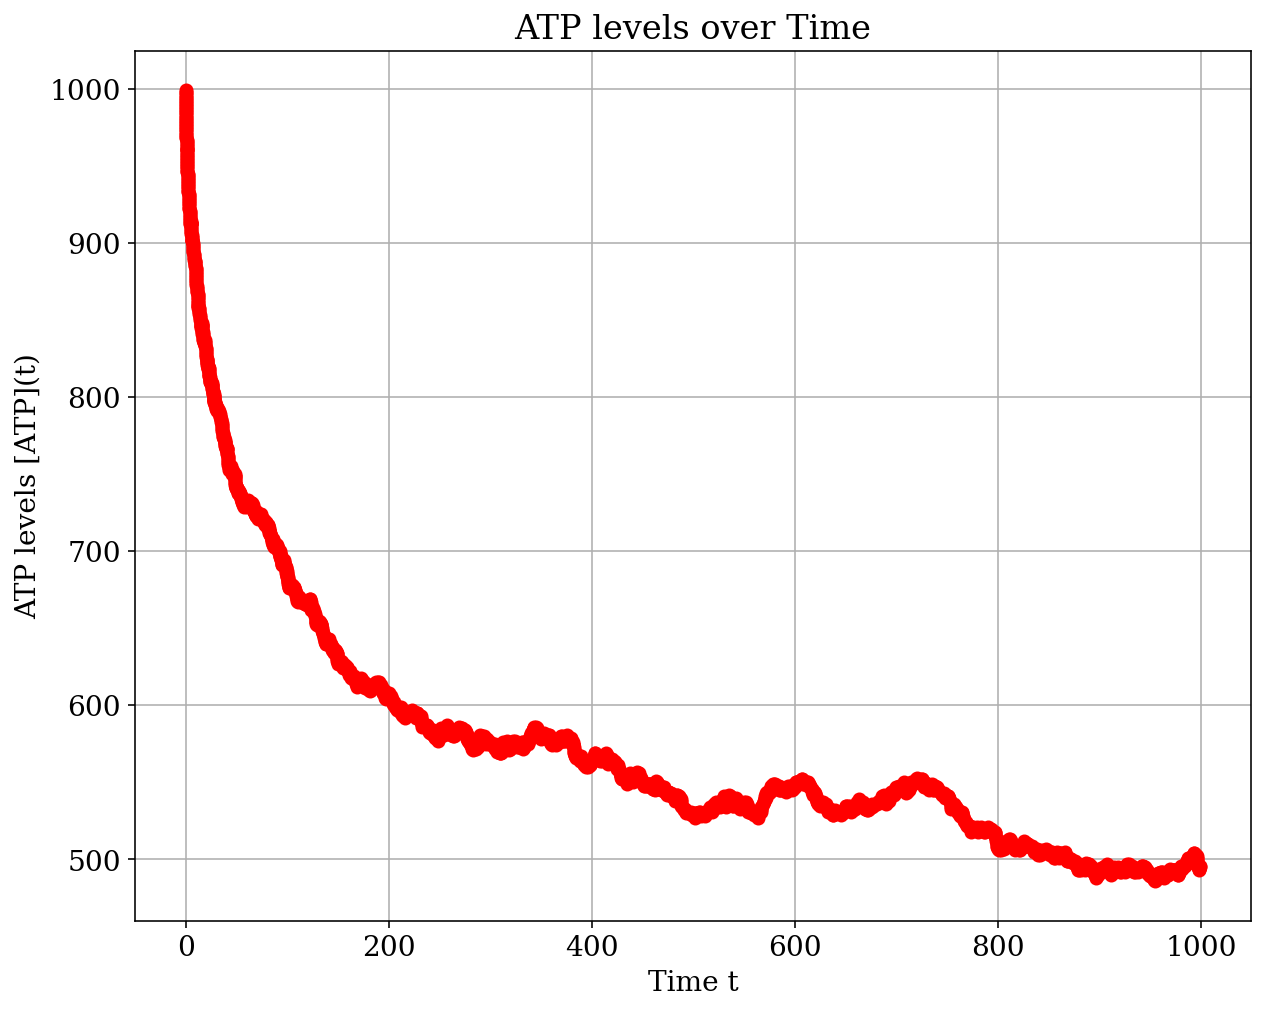

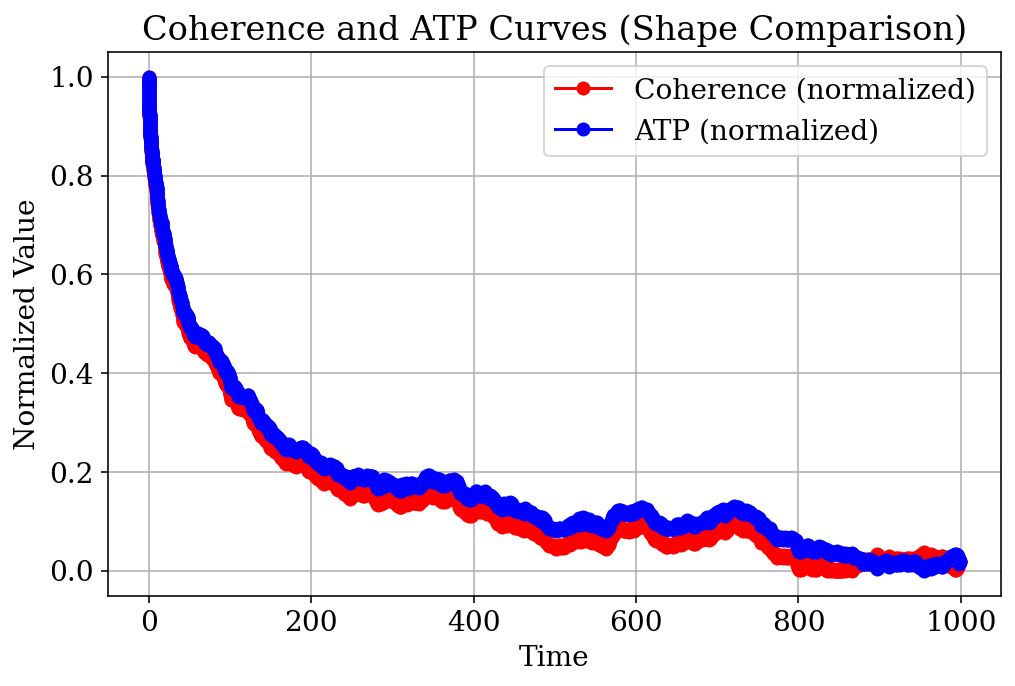

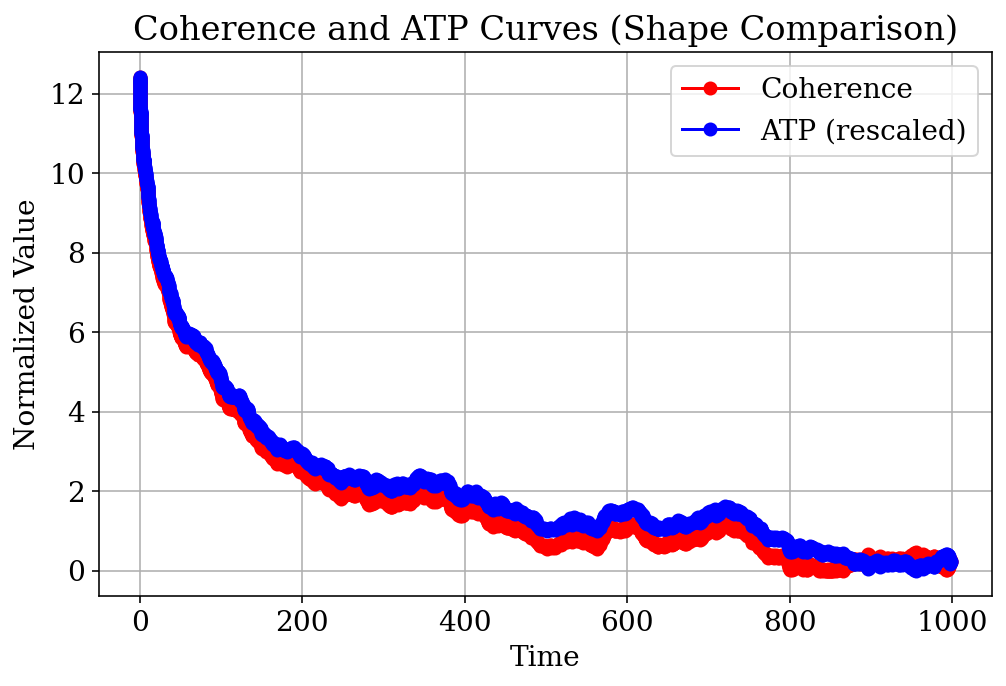

In [13]:
# Parameters
N = 40
F_init = 1.0
T_max = 1000
n_ATP_init = 1000
n_ADP_init = 10

# Run the 3D Gillespie simulation
trajectory, coherence_record, atp_record, transition_matrices, states_visited = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init)

# Plot the 3D trajectory
plot_trajectory_3d(trajectory)

# Plot the 2D trajectory
plot_states(states_visited)

# Plot the coherence over time
plot_coherence(coherence_record)

# Plot the ATP levels over time
plot_atp(atp_record)

# Plot both
plot_both_aligned(coherence_record, atp_record, method='normalize')
plot_both_aligned(coherence_record, atp_record, method='rescale_atp')

In [7]:
def correlation_function_general(t, W):
    exp_Wt = scipy.linalg.expm(W * t)
    return exp_Wt[0][0]  # P(state=0 at t | state=0 at t=0)

def damped_cosine(t, A, X_R, X_I, phi):
    return A * np.exp(-X_R * t) * np.cos(X_I * t + phi)

def relabel_matrix(W, shift):
    N = W.shape[0]
    indices = np.arange(N)
    new_indices = (indices - shift) % N
    return W[np.ix_(new_indices, new_indices)]

def compute_oscillation_periods(transition_matrices):
    times = []
    periods = []

    for t, Q in transition_matrices:
        eigenvalues = eig(Q, right=False)
        eigenvalues = sorted(eigenvalues, key=lambda x: np.real(x))
        lambda_1 = eigenvalues[-2]
        X_I = np.imag(lambda_1)

        if X_I != 0:
            period = 2 * np.pi / abs(X_I)
        else:
            period = np.inf  # No oscillation

        times.append(t)
        periods.append(period)

    return times, periods

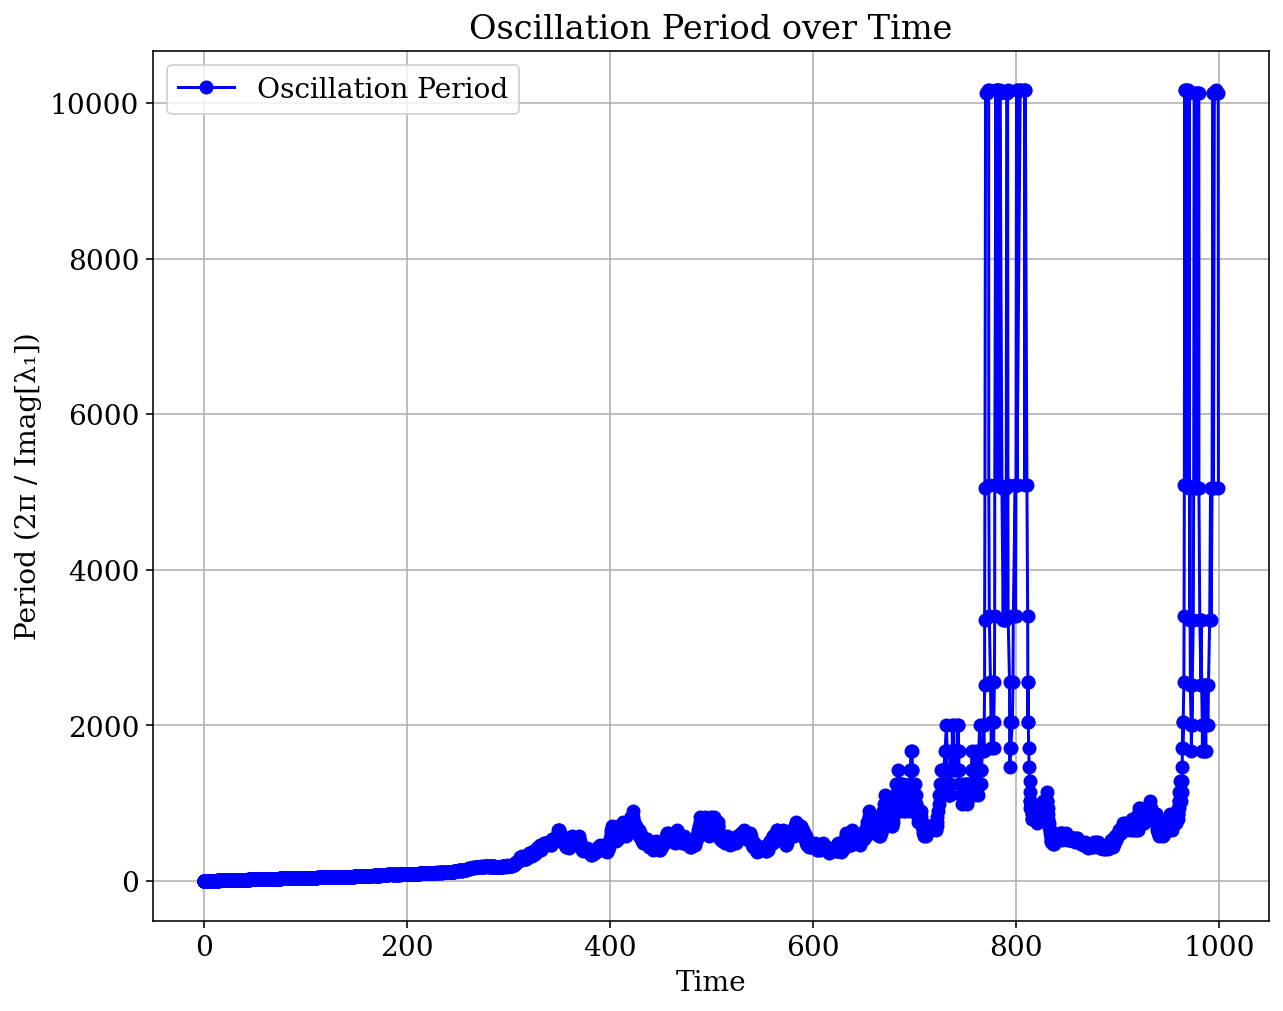

In [10]:
times, periods = compute_oscillation_periods(transition_matrices)

plt.figure()
plt.plot(times, periods, '-o', color = 'blue', label='Oscillation Period')
plt.xlabel('Time')
plt.ylabel('Period (2π / Imag[λ₁])')
plt.title('Oscillation Period over Time')
plt.grid(True)
plt.legend()
plt.show()


100%|████████████████████████████████████████| 500/500 [00:00<00:00, 986.47it/s]


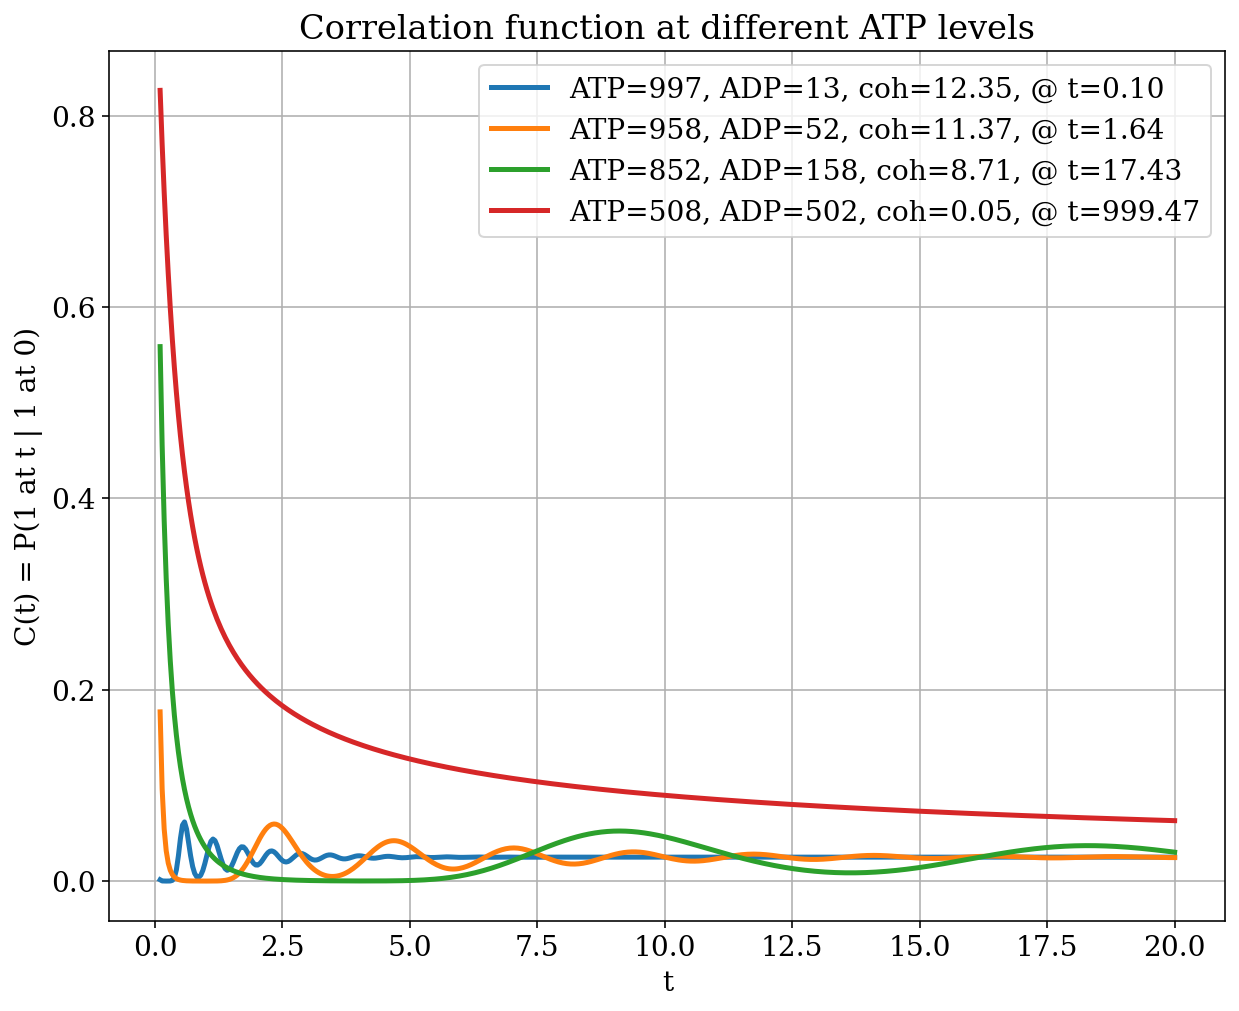

In [23]:
# Time points for the plot
# Pick a few specific time points along the simulation
# (e.g., early, mid, and late in ATP depletion)
#indices_to_check = [5]
indices_to_check = [5, 50, 200, len(transition_matrices) - 1]  # indices into transition_matrices list

for idx in indices_to_check:
    
    t_sim, W_orig = transition_matrices[idx]
    atp_level = trajectory[idx][2] # ATP count at this time
    adp_level = trajectory[idx][3] # ADP count at this time
    current_state = trajectory[idx][1]  # e.g., 5
    
    # Relabel W so that current_state becomes 0
    W = relabel_matrix(W_orig, current_state)
    
    # Evaluate correlation function at many future times
    times = np.linspace(0.1, 20, 500)
    correlation_values = [correlation_function_general(t, W) for t in tqdm(times)]
    
    try:
        p0 = [1.0, 0.1, 1.0, 0.0]  # Initial guess: [A, decay, freq, phase]
        params, _ = curve_fit(damped_cosine, times, correlation_values, p0=p0, maxfev=10000)
        A_fit, X_R_fit, X_I_fit, phi_fit = params
        coherence_fit = X_I_fit / abs(X_R_fit)
    except RuntimeError:
        A_fit, X_R_fit, X_I_fit, phi_fit = [np.nan] * 4
        coherence_fit = np.nan
    
    coherence = compute_oscillation_coherence(W)
    
    plt.plot(times, correlation_values, label=f'ATP={atp_level}, ADP={adp_level}, coh={coherence:.2f}, @ t={t_sim:.2f}', linewidth=2.5)
    #plt.plot(times, damped_cosine(times, *params), linestyle='--', label=f'Fit @ t={t_sim:.2f}')

plt.xlabel('t')
plt.ylabel('C(t) = P(1 at t | 1 at 0)')
plt.title('Correlation function at different ATP levels')
plt.legend()
plt.grid(True)
plt.show()

995 15


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1044.29it/s]


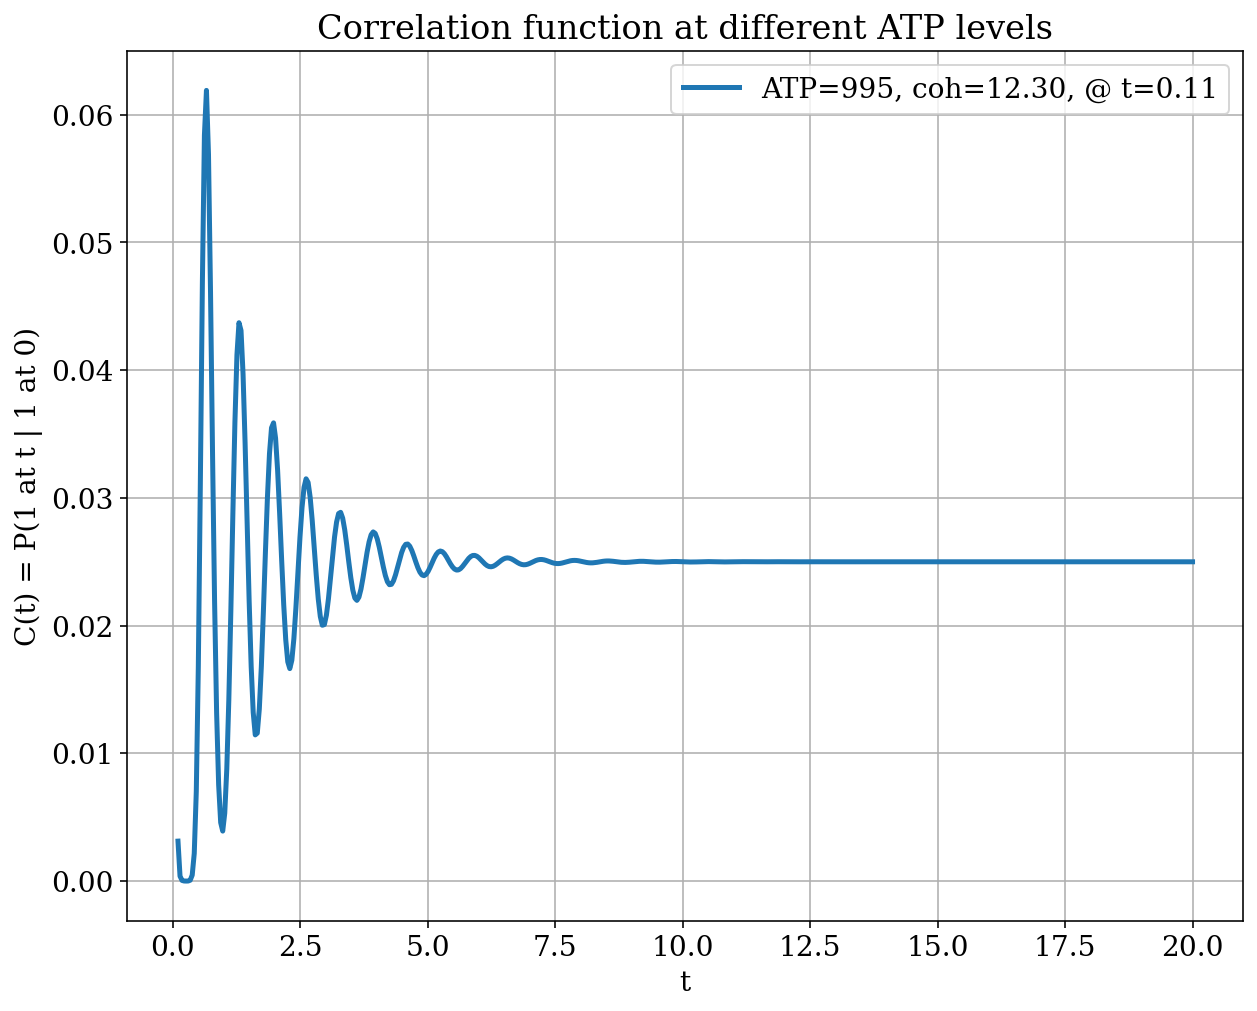

In [12]:
# Time points for the plot
# Pick a few specific time points along the simulation
# (e.g., early, mid, and late in ATP depletion)
#indices_to_check = [5]
indices_to_check = [5]  # indices into transition_matrices list

for idx in indices_to_check:
    t_sim, W = transition_matrices[idx]
    atp_level = trajectory[idx][2]  # ATP count at this time
    adp_level = trajectory[idx][3]  # ATP count at this time
    print(atp_level,adp_level)
    
    # Evaluate correlation function at many future times
    times = np.linspace(0.1, 20, 500)
    correlation_values = [correlation_function_general(t, W) for t in tqdm(times)]
    
    try:
        p0 = [1.0, 0.1, 1.0, 0.0]  # Initial guess: [A, decay, freq, phase]
        params, _ = curve_fit(damped_cosine, times, correlation_values, p0=p0, maxfev=10000)
        A_fit, X_R_fit, X_I_fit, phi_fit = params
        coherence_fit = X_I_fit / abs(X_R_fit)
    except RuntimeError:
        A_fit, X_R_fit, X_I_fit, phi_fit = [np.nan] * 4
        coherence_fit = np.nan
    
    coherence = compute_oscillation_coherence(W)
    
    plt.plot(times, correlation_values, label=f'ATP={atp_level}, coh={coherence:.2f}, @ t={t_sim:.2f}', linewidth=2.5)
    #plt.plot(times, damped_cosine(times, *params), linestyle='--', label=f'Fit @ t={t_sim:.2f}')

plt.xlabel('t')
plt.ylabel('C(t) = P(1 at t | 1 at 0)')
plt.title('Correlation function at different ATP levels')
plt.legend()
plt.grid(True)
plt.show()

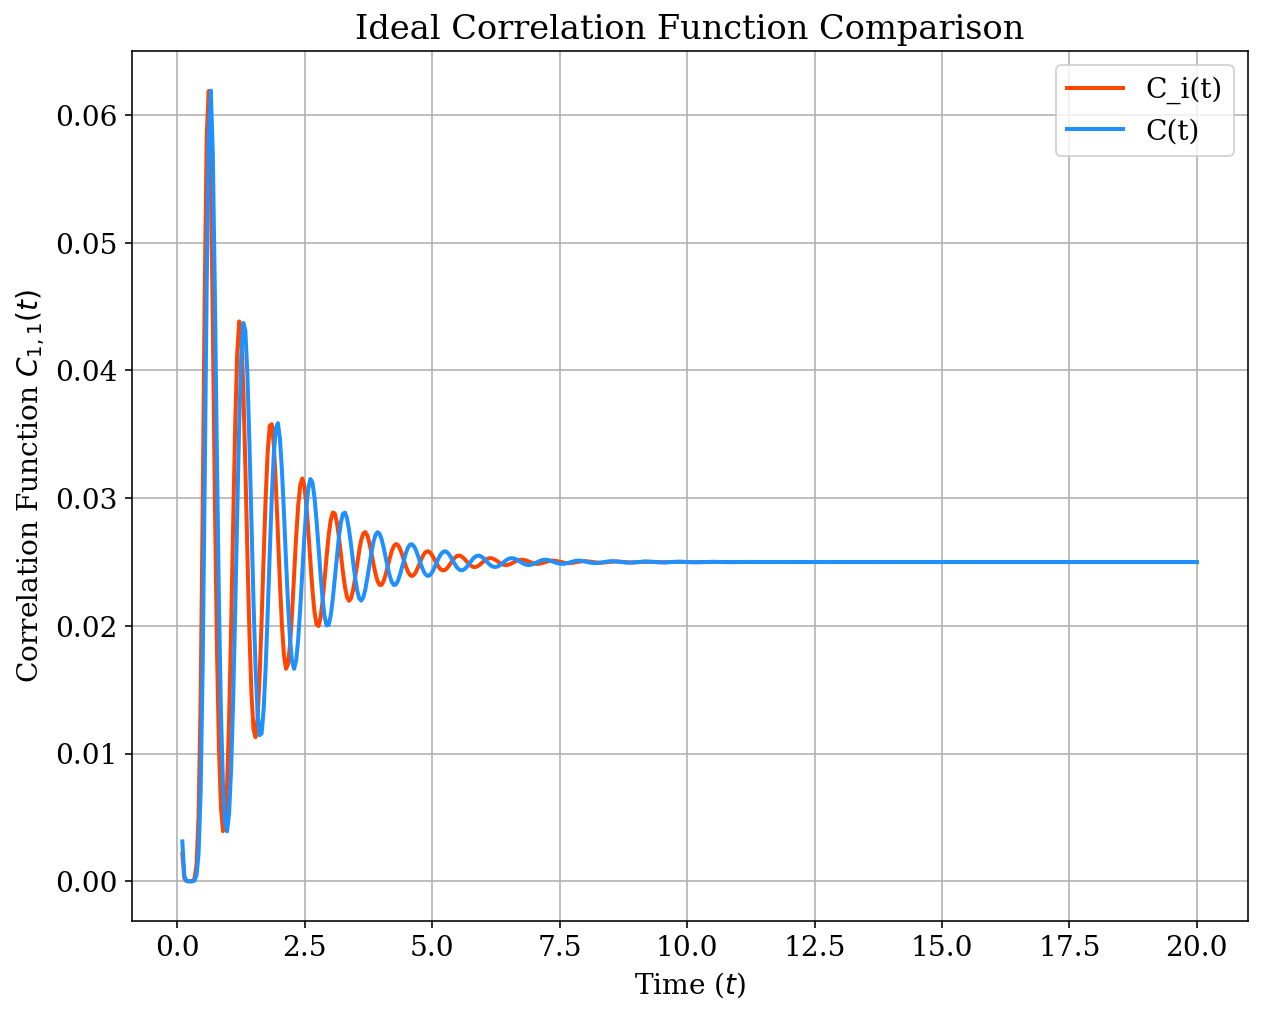

In [13]:
# Compute the ideal C(t)

k_m = 1.0
A = compute_entropy_production(atp_level, adp_level)
k_p = np.round(k_m*np.exp(A/N),4)

W = construct_transition_matrix(N, atp_level, adp_level)

times = np.linspace(0.1, 20, 500)  # time from 0 to 1.5 with 500 pts
correlation_values_ideal = [correlation_function_general(t, W) for t in times]

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(times, correlation_values_ideal, color = "orangered", linewidth=2, label='C_i(t)')
plt.plot(times, correlation_values, color = "dodgerblue", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Ideal Correlation Function Comparison')
plt.legend()
plt.grid()
plt.show()

950 60


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1422.04it/s]


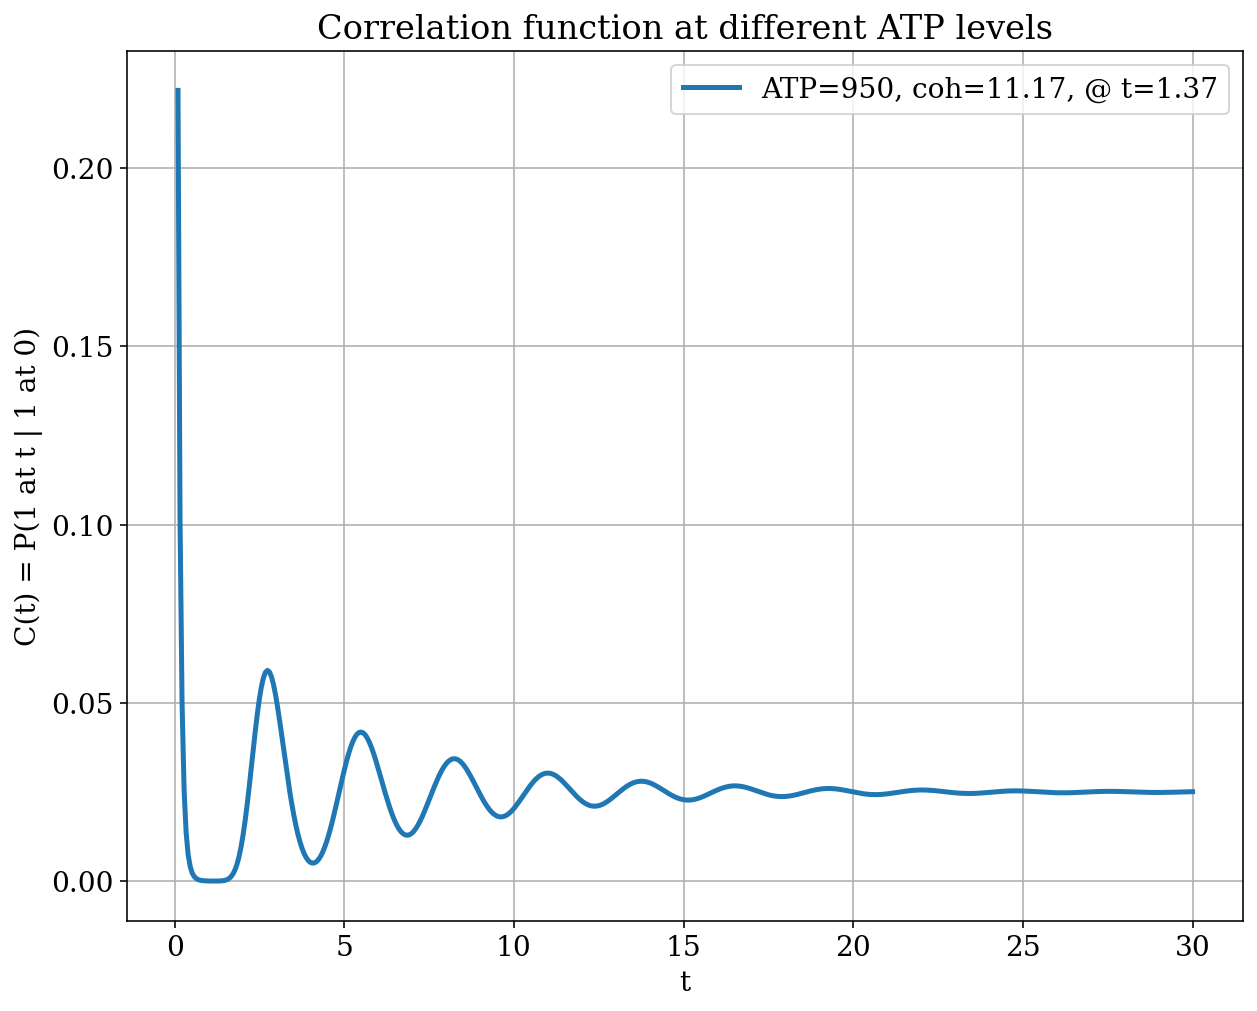

In [14]:
# Time points for the plot
# Pick a few specific time points along the simulation
# (e.g., early, mid, and late in ATP depletion)
#indices_to_check = [5]
indices_to_check = [50]  # indices into transition_matrices list

for idx in indices_to_check:
    t_sim, W = transition_matrices[idx]
    atp_level = trajectory[idx][2]  # ATP count at this time
    adp_level = trajectory[idx][3]  # ATP count at this time
    print(atp_level,adp_level)
    
    # Evaluate correlation function at many future times
    times = np.linspace(0.1, 30, 500)
    correlation_values = [correlation_function_general(t, W) for t in tqdm(times)]
    
    try:
        p0 = [1.0, 0.1, 1.0, 0.0]  # Initial guess: [A, decay, freq, phase]
        params, _ = curve_fit(damped_cosine, times, correlation_values, p0=p0, maxfev=10000)
        A_fit, X_R_fit, X_I_fit, phi_fit = params
        coherence_fit = X_I_fit / abs(X_R_fit)
    except RuntimeError:
        A_fit, X_R_fit, X_I_fit, phi_fit = [np.nan] * 4
        coherence_fit = np.nan
    
    coherence = compute_oscillation_coherence(W)
    
    plt.plot(times, correlation_values, label=f'ATP={atp_level}, coh={coherence:.2f}, @ t={t_sim:.2f}', linewidth=2.5)
    #plt.plot(times, damped_cosine(times, *params), linestyle='--', label=f'Fit @ t={t_sim:.2f}')

plt.xlabel('t')
plt.ylabel('C(t) = P(1 at t | 1 at 0)')
plt.title('Correlation function at different ATP levels')
plt.legend()
plt.grid(True)
plt.show()

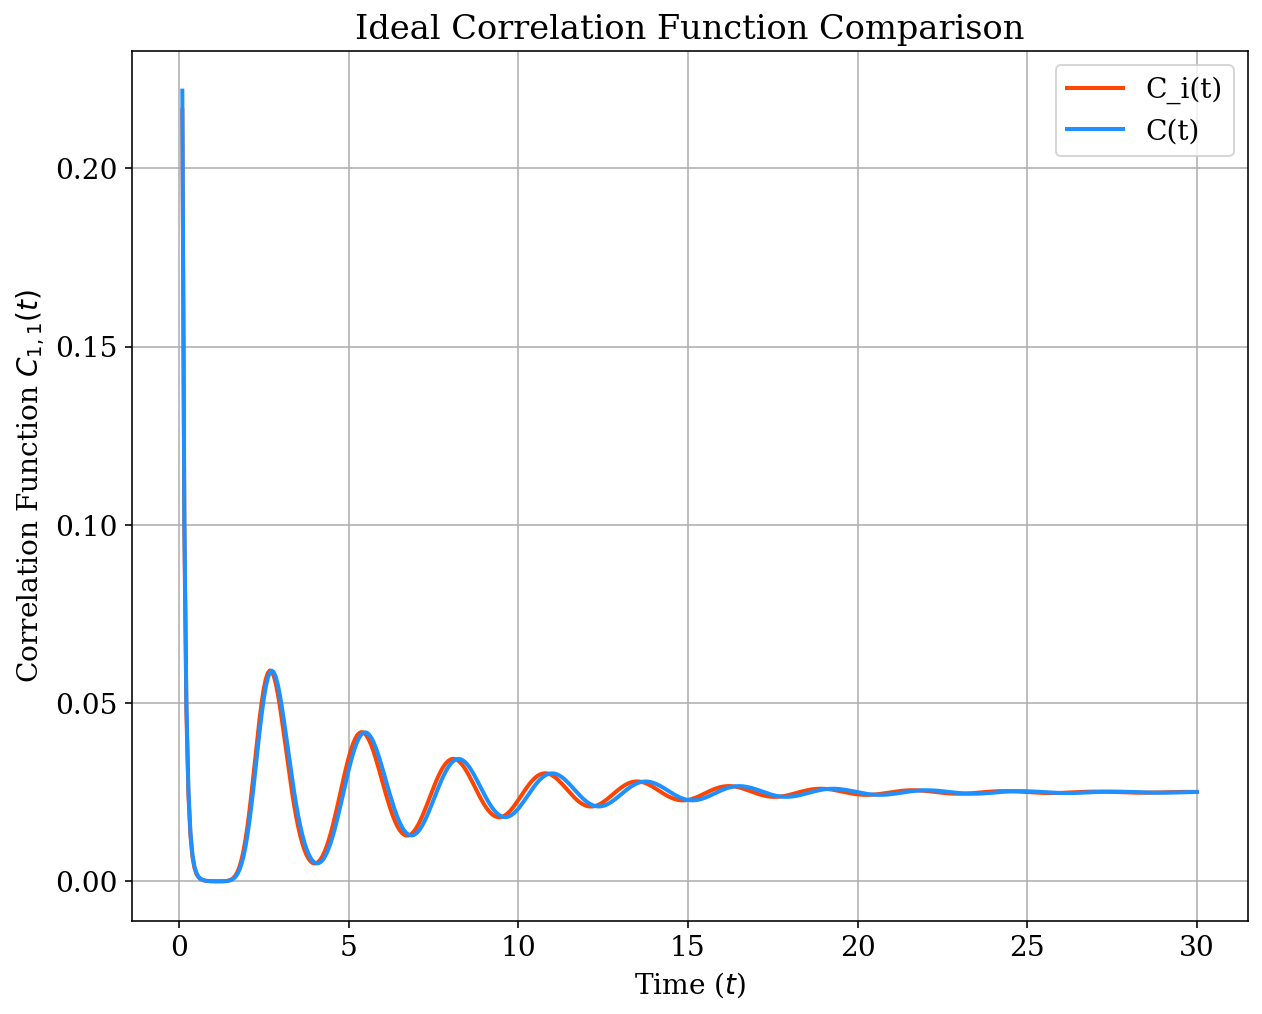

In [15]:
# Compute the ideal C(t)

k_m = 1.0
A = compute_entropy_production(atp_level, adp_level)
k_p = np.round(k_m*np.exp(A/N),4)

W = construct_transition_matrix(N, atp_level, adp_level)

times = np.linspace(0.1, 30, 500)  # time from 0 to 1.5 with 500 pts
correlation_values_ideal = [correlation_function_general(t, W) for t in times]

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(times, correlation_values_ideal, color = "orangered", linewidth=2, label='C_i(t)')
plt.plot(times, correlation_values, color = "dodgerblue", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Ideal Correlation Function Comparison')
plt.legend()
plt.grid()
plt.show()

842 168


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1547.73it/s]


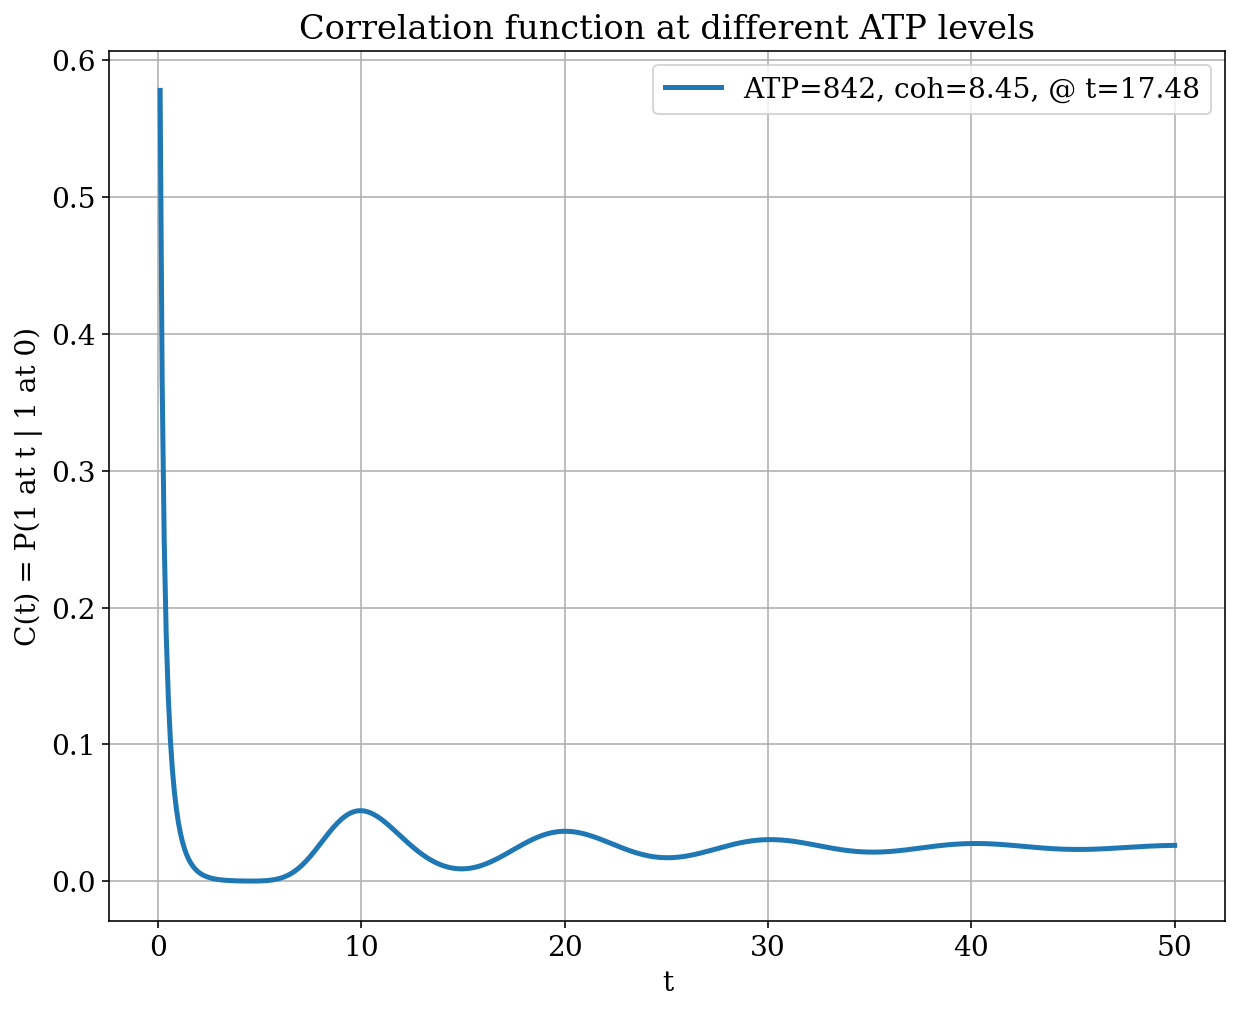

In [16]:
# Time points for the plot
# Pick a few specific time points along the simulation
# (e.g., early, mid, and late in ATP depletion)
#indices_to_check = [5]
indices_to_check = [200]  # indices into transition_matrices list

for idx in indices_to_check:
    t_sim, W = transition_matrices[idx]
    atp_level = trajectory[idx][2]  # ATP count at this time
    adp_level = trajectory[idx][3]  # ATP count at this time
    print(atp_level,adp_level)
    
    # Evaluate correlation function at many future times
    times = np.linspace(0.1, 50, 500)
    correlation_values = [correlation_function_general(t, W) for t in tqdm(times)]
    
    try:
        p0 = [1.0, 0.1, 1.0, 0.0]  # Initial guess: [A, decay, freq, phase]
        params, _ = curve_fit(damped_cosine, times, correlation_values, p0=p0, maxfev=10000)
        A_fit, X_R_fit, X_I_fit, phi_fit = params
        coherence_fit = X_I_fit / abs(X_R_fit)
    except RuntimeError:
        A_fit, X_R_fit, X_I_fit, phi_fit = [np.nan] * 4
        coherence_fit = np.nan
    
    coherence = compute_oscillation_coherence(W)
    
    plt.plot(times, correlation_values, label=f'ATP={atp_level}, coh={coherence:.2f}, @ t={t_sim:.2f}', linewidth=2.5)
    #plt.plot(times, damped_cosine(times, *params), linestyle='--', label=f'Fit @ t={t_sim:.2f}')

plt.xlabel('t')
plt.ylabel('C(t) = P(1 at t | 1 at 0)')
plt.title('Correlation function at different ATP levels')
plt.legend()
plt.grid(True)
plt.show()

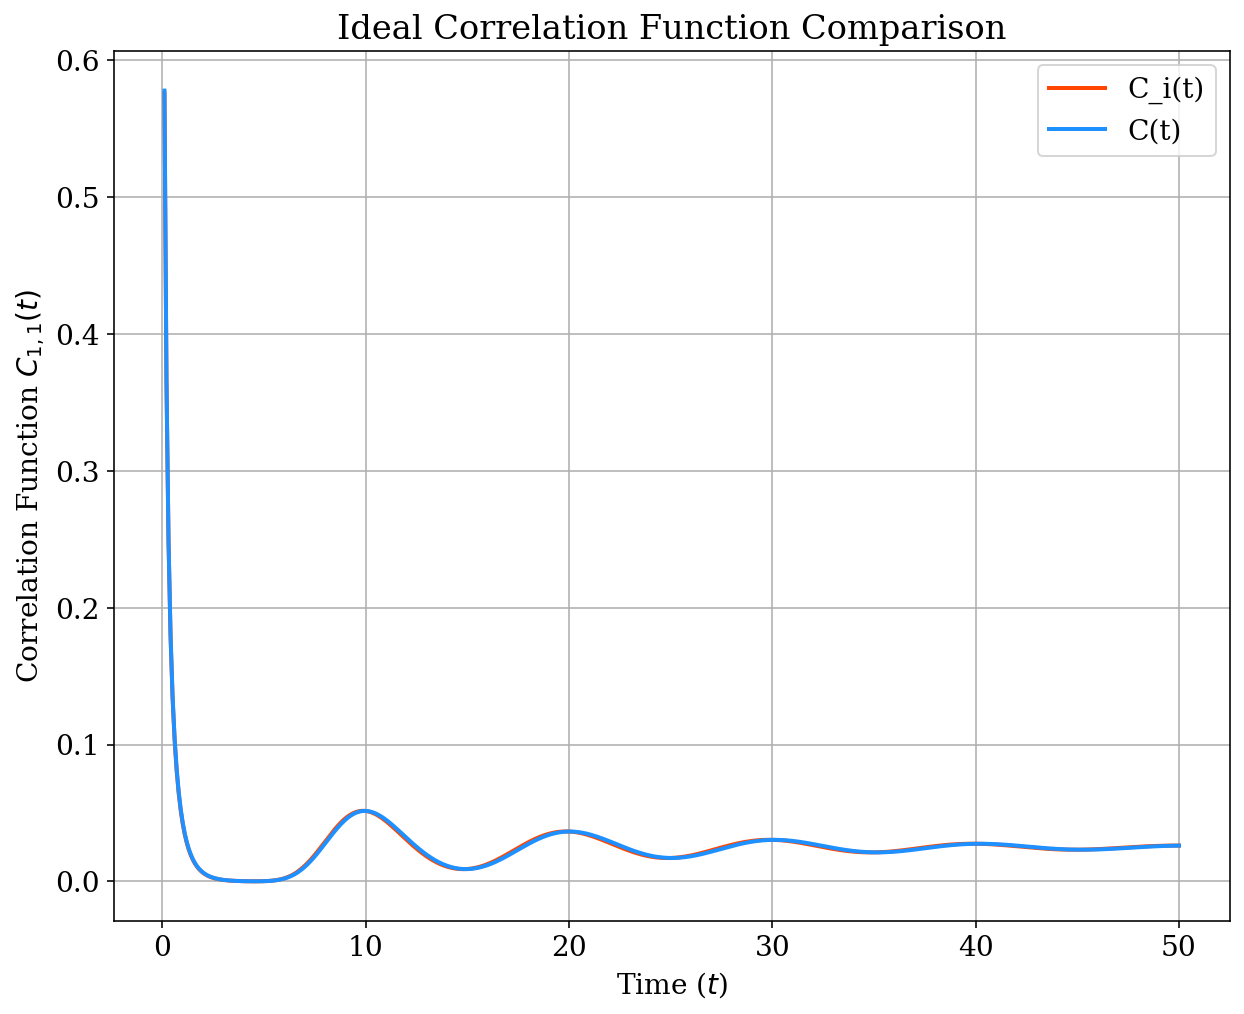

In [17]:
# Compute the ideal C(t)

k_m = 1.0
A = compute_entropy_production(atp_level, adp_level)
k_p = np.round(k_m*np.exp(A/N),4)

W = construct_transition_matrix(N, atp_level, adp_level)

times = np.linspace(0.1, 50, 500)  # time from 0 to 1.5 with 500 pts
correlation_values_ideal = [correlation_function_general(t, W) for t in times]

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(times, correlation_values_ideal, color = "orangered", linewidth=2, label='C_i(t)')
plt.plot(times, correlation_values, color = "dodgerblue", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Ideal Correlation Function Comparison')
plt.legend()
plt.grid()
plt.show()

In [18]:
def plot_average_results(avg_times, avg_coherence, avg_atp):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    axs[0].plot(avg_times, avg_coherence, '-o', color = 'blue')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Average Coherence')
    axs[0].set_title('Average Oscillation Coherence over Time')
    axs[0].grid(True)

    axs[1].plot(avg_times, avg_atp, '-o', color = 'red')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Average ATP Levels')
    axs[1].set_title('Average ATP Levels over Time')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_both_average_aligned(avg_times, avg_coherence, avg_atp, method='normalize'):

    if method == 'normalize':
        # Normalize both to [0, 1]
        coh_min, coh_max = min(avg_coherence), max(avg_coherence)
        atp_min, atp_max = min(avg_atp), max(avg_atp)

        norm_coh = [(c - coh_min) / (coh_max - coh_min) for c in avg_coherence]
        norm_atp = [(a - atp_min) / (atp_max - atp_min) for a in avg_atp]

        label_coh = 'Coherence (normalized)'
        label_atp = 'ATP (normalized)'

    elif method == 'rescale_atp':
        # Rescale ATP to match coherence range directly
        coh_min, coh_max = min(avg_coherence), max(avg_coherence)
        atp_min, atp_max = min(avg_atp), max(avg_atp)

        scale = (coh_max - coh_min) / (atp_max - atp_min)
        shift = coh_min - scale * atp_min
        norm_coh = avg_coherence
        norm_atp = [scale * a + shift for a in avg_atp]

        label_coh = 'Coherence'
        label_atp = 'ATP (rescaled)'

    else:
        raise ValueError("Method must be 'normalize' or 'rescale_atp'.")

    plt.figure(figsize=(8, 5))
    plt.plot(times_coh, norm_coh, '-o', color='red', label=label_coh)
    plt.plot(times_atp, norm_atp, '-o', color='blue', label=label_atp)
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title('Coherence and ATP Curves (Shape Comparison)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
from scipy.interpolate import interp1d

# Parameters
N = 40
F_init = 1.0
T_max = 1000
n_ATP_init = 1000
n_ADP_init = 10
n_trajectories = 1000

# Common time grid
time_grid = np.linspace(0, T_max, 200)
all_coherence_interp = []
all_atp_interp = []

for _ in range(n_trajectories):
    trajectory, coherence_record, atp_record, transition_matrices, states_visited = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init)

    times_coh, coherences = zip(*coherence_record)
    times_atp, atp_levels = zip(*atp_record)

    # Interpolate onto common time grid
    interp_coh = interp1d(times_coh, coherences, bounds_error=False, fill_value='extrapolate')
    interp_atp = interp1d(times_atp, atp_levels, bounds_error=False, fill_value='extrapolate')

    all_coherence_interp.append(interp_coh(time_grid))
    all_atp_interp.append(interp_atp(time_grid))

# Average over trajectories
avg_coherence = np.mean(all_coherence_interp, axis=0)
avg_atp = np.mean(all_atp_interp, axis=0)

# Plot averaged results
plot_average_results(time_grid, avg_coherence, avg_atp)
plot_both_average_aligned(time_grid, avg_coherence, avg_atp, method='normalize')

KeyboardInterrupt: 

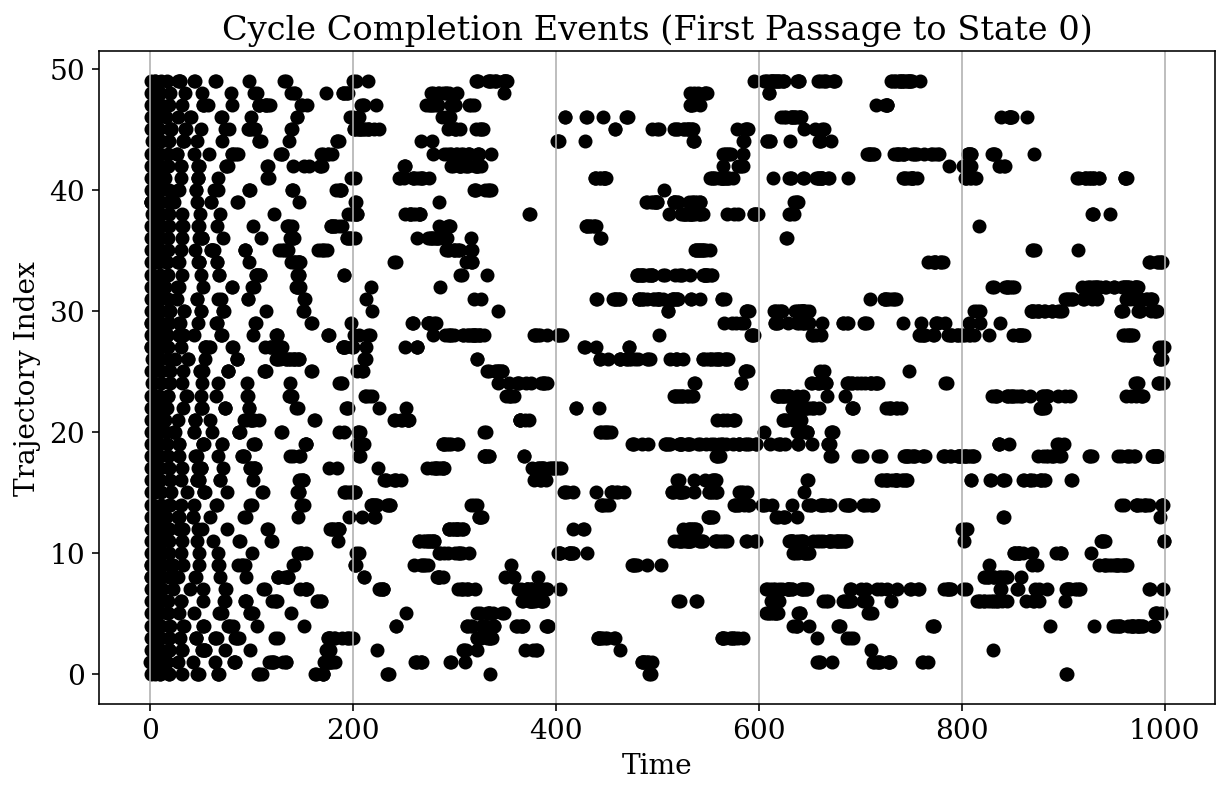

In [28]:
def gillespie_with_first_passage(N, T_max, n_ATP_init, n_ADP_init):
    state = 0
    time = 0.0
    n_ATP, n_ADP = n_ATP_init, n_ADP_init
    times = [0.0]
    states = [state]
    return_times = []

    while time < T_max:
        delta_s = compute_entropy_production(n_ATP, n_ADP)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        forward_rate = k_plus if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0
        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break

        tau = -np.log(np.random.rand()) / total_rate
        time += tau

        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N
            n_ATP = max(n_ATP - 1, 0)
            n_ADP += 1
        else:
            state = (state - 1) % N
            n_ATP += 1
            n_ADP = max(n_ADP - 1, 0)

        times.append(time)
        states.append(state)

        if state == 0 and len(states) > 1:  # return to 0 (exclude start)
            return_times.append(time)

    return return_times

n_trajectories = 50
T_max = 1000
N = 40
n_ATP_init = 1000
n_ADP_init = 10

all_return_times = []
for _ in range(n_trajectories):
    rt = gillespie_with_first_passage(N, T_max, n_ATP_init, n_ADP_init)
    all_return_times.append(rt)
    
plt.figure(figsize=(10, 6))
for i, rt in enumerate(all_return_times):
    plt.scatter(rt, [i] * len(rt), marker='o', color='black')

plt.xlabel('Time')
plt.ylabel('Trajectory Index')
plt.title('Cycle Completion Events (First Passage to State 0)')
plt.grid(True, axis='x')
plt.show()

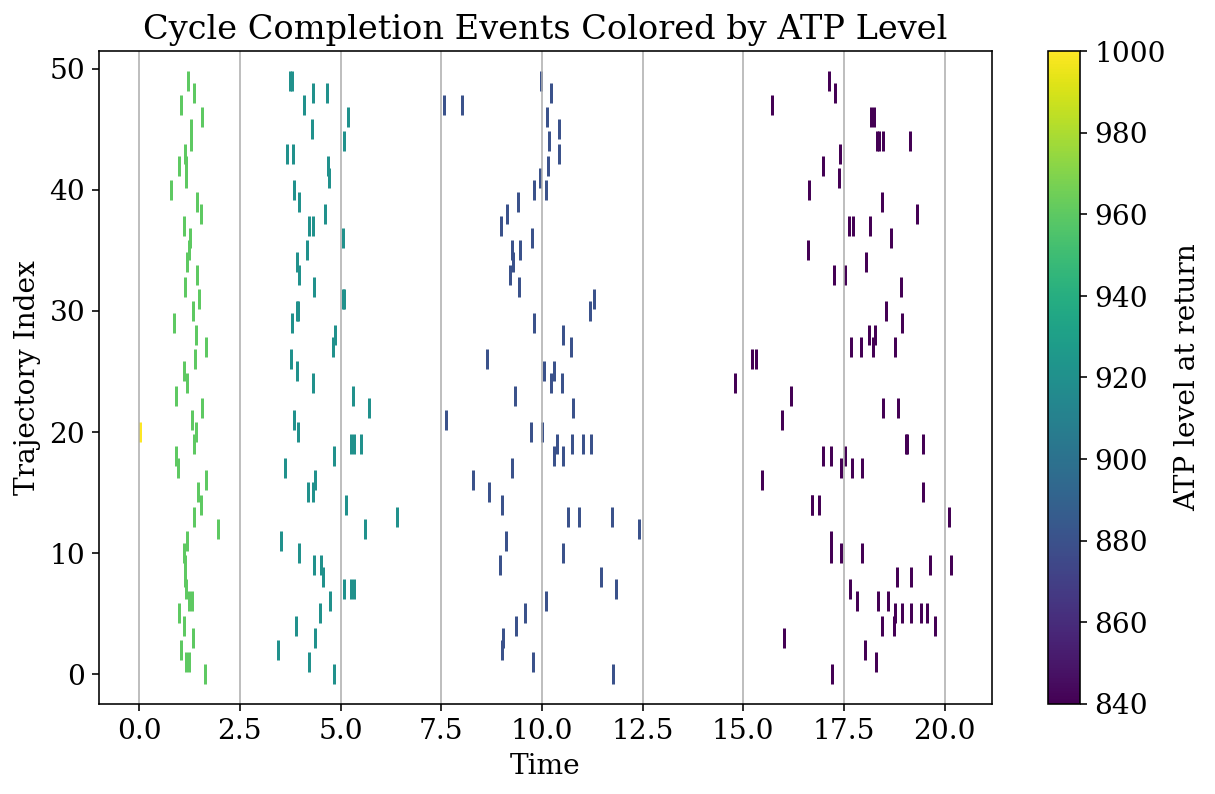

In [22]:
def gillespie_with_first_passage_atp(N, T_max, n_ATP_init, n_ADP_init):
    state = 0
    time = 0.0
    n_ATP, n_ADP = n_ATP_init, n_ADP_init
    return_events = []

    while time < T_max:
        delta_s = compute_entropy_production(n_ATP, n_ADP)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        forward_rate = k_plus if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0
        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break

        tau = -np.log(np.random.rand()) / total_rate
        time += tau

        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N
            n_ATP = max(n_ATP - 1, 0)
            n_ADP += 1
        else:
            state = (state - 1) % N
            n_ATP += 1
            n_ADP = max(n_ADP - 1, 0)

        if state == 0 and time > 0.01:  # exclude initial state
            return_events.append((time, n_ATP))

    return return_events

n_trajectories = 50
T_max = 20
N = 40
n_ATP_init = 1000
n_ADP_init = 10

all_events = []  # list of (time, ATP, trajectory_id)
for i in range(n_trajectories):
    events = gillespie_with_first_passage_atp(N, T_max, n_ATP_init, n_ADP_init)
    for time, atp in events:
        all_events.append((time, atp, i))

times, atps, traj_ids = zip(*all_events)

plt.figure(figsize=(10, 6))
sc = plt.scatter(times, traj_ids, c=atps, cmap='viridis', marker='|', s=100)
cbar = plt.colorbar(sc)
cbar.set_label('ATP level at return')

plt.xlabel('Time')
plt.ylabel('Trajectory Index')
plt.title('Cycle Completion Events Colored by ATP Level')
plt.grid(True, axis='x')
plt.show()